In [72]:
import os
import json
import random
import statistics
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from itertools import compress 
from collections import Counter
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from sklearn.metrics import recall_score
from rank_bm25 import BM25Okapi, BM25L, BM25Plus
from sklearn.metrics import average_precision_score

In [73]:
ls

650Project.ipynb                    model.py
650venv/                            requirements.txt
SI650_ProjectProposal.pdf           space_data/
SI650_ProjectProposal_resubmit.pdf  space_project.csv
SI650_ProjectUpdate.pdf             templates/
__pycache__/                        text_copying.ipynb
app.py


In [74]:
df = pd.read_csv('space_project.csv')
df

,text_id,category_label,query1,query2,query3,query4,query5,query6,query7,query8,...,query11,query12,query13,query14,query15,query16,query17,query18,query19,query20
0,1,alt,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,alt,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,alt,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,alt,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,alt,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1815,4518,hubble space telescope,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1816,4519,hubble space telescope,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1817,4520,hubble space telescope,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1818,4521,hubble space telescope,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [75]:
DIR = '/Users/img/Desktop/SI650/Project/space_data'
pics = [name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]

In [76]:
query_dict = {
    'query1': 'approach and landing tests', 
    'query2': 'first space shuttle launch', 
    'query3': 'sally ride', 
    'query4': 'STS-26', 
    'query5': 'last space shuttle launch', 
    'query6': 'untethered space walk', 
    'query7': 'first african american astronaut', 
    'query8': 'space shuttle challenger', 
    'query9': 'space shuttle columbia', 
    'query10': 'oldest astronaut to launch in shuttle', 
    'query11': 'what is the space shuttle program', 
    'query12': 'atlantis first flight', 
    'query13': 'first space walk', 
    'query14': 'STS-51-j', 
    'query15': 'STS-127', 
    'query16': 'STS-124', 
    'query17': 'apollo 1 fire',
    'query18': 'first moon landing',
    'query19': 'what is the hubble space telescope',
    'query20': 'international space station'  
}

q_list = list(query_dict.keys())


test_queries_relevant_docs = {}

for  x in list(query_dict.keys()):
    q1_relevance = list(df[x])
    q1_relevance = [True if y==1 else False for y in q1_relevance]
    
    ids_q1 = list(df['text_id'])
    res = list(compress(ids_q1, q1_relevance)) 
    
    test_queries_relevant_docs[x] = res

In [77]:
id_to_text = {}
for x in pics:
    inx = x.index('.')
    if inx > 0:
        f = open("/Users/img/Desktop/SI650/Project/space_data/"+x, "r")
        article = " ".join(f.read().split())
#         article = article.lower()
        id_to_text[int(x[:inx])] = article
        
docs = list(id_to_text.values())
ids = list(id_to_text.keys())

In [79]:
print('There are '+str(len(id_to_text))+' articles')

There are 1820 articles


In [218]:
doc_lengths = [len(x.split()) for x in docs]
print('Min filtered doc length:', (min(doc_lengths)))
print('Max filtered doc length:', (max(doc_lengths)))
print('Avgerage filtered doc length:', (sum(doc_lengths)/len(doc_lengths)))
avg_dl = sum(doc_lengths)/len(doc_lengths)

Min filtered doc length: 14
Max filtered doc length: 13743
Avgerage filtered doc length: 852.6697802197803


(0, 42)

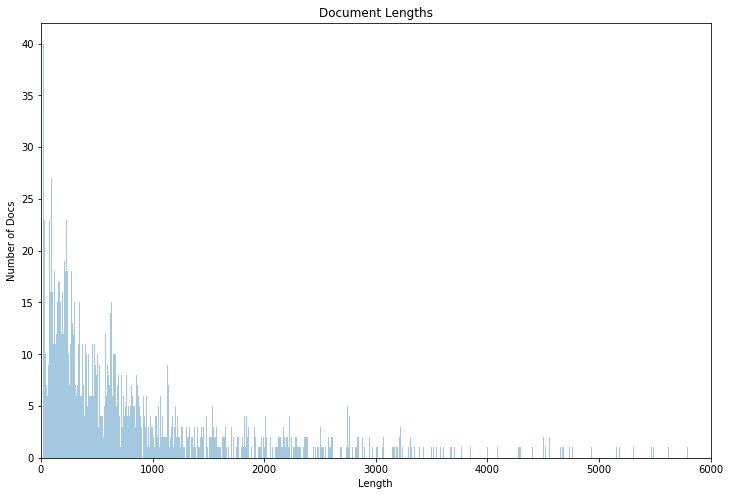

In [225]:
fig, ax = plt.subplots(figsize=(12, 8))
g = sns.distplot(doc_lengths,bins=2000,kde=False,ax=ax)

# ax = sns.boxplot('Day', 'Count', data= gg)
g.set_title('Document Lengths')
g.set_ylabel('Number of Docs')
g.set_xlabel('Length')
plt.xlim(0,6000)
plt.ylim(0,42)

In [9]:
# Filtering

In [80]:
filtered_docs = []
filtered_ids = []

df_filter = []

for x in range(len(docs)):
    if len(docs[x].split())<30:
        df_filter.append(0)
        pass
    
    if len(docs[x].split())>=30 and len(docs[x].split())<=1000:
        filtered_docs.append(docs[x])
        filtered_ids.append(ids[x])
        df_filter.append(1)
    if len(docs[x].split())>1000:
        y = docs[x].split()[:1000]
        y = " ".join(y)
        
        df_filter.append(1)
        filtered_docs.append(y)
        filtered_ids.append(ids[x])

filtered_doc_lengths = [len(x.split()) for x in filtered_docs]

In [226]:
len(filtered_docs)

1762

In [81]:
print('Min filtered doc length:', (min(filtered_doc_lengths)))
print('Max filtered doc length:', (max(filtered_doc_lengths)))
print('Avgerage filtered doc length:', (sum(filtered_doc_lengths)/len(filtered_doc_lengths)))
avg_dl = sum(filtered_doc_lengths)/len(filtered_doc_lengths)

Min filtered doc length: 30
Max filtered doc length: 1000
Avgerage filtered doc length: 559.2797956867196


In [82]:
category_label = list(df['category_label'])

t = list(set(category_label))

print('Number of filtered documents:', (len(filtered_docs)))

print('Number of unique categories:', (len(t)))

print("Average number of docs per category:",str(len(category_label)/len(t)))

Number of filtered documents: 1762
Number of unique categories: 156
Average number of docs per category: 11.666666666666666


In [84]:
df1 = df

In [85]:
# Remove filtered_docs from df1

df1['filter'] = df_filter

df1 = df1.loc[df['filter'] == 1]

df1

,text_id,category_label,query1,query2,query3,query4,query5,query6,query7,query8,...,query12,query13,query14,query15,query16,query17,query18,query19,query20,filter
0,1,alt,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,alt,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,3,alt,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,alt,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,alt,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1814,4517,hubble space telescope,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1815,4518,hubble space telescope,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1816,4519,hubble space telescope,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1817,4520,hubble space telescope,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [86]:
del df1['filter']

In [87]:
id_to_text_new = {}

new_id = list(df['text_id'])

for x in new_id:
    if x in id_to_text:
        id_to_text_new[x] = id_to_text[x]
    

In [88]:
id_to_text = id_to_text_new

In [89]:
json = json.dumps(id_to_text)
f = open("id_to_text.json","w")
f.write(json)
f.close()

In [92]:
# Graphing number of relevant docs for each of our test queries
cols = list(df1.columns)

query_cols = cols[2:]
query_cols

num_relevant_docs = [list(df1[x]).count(1) for x in query_cols]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

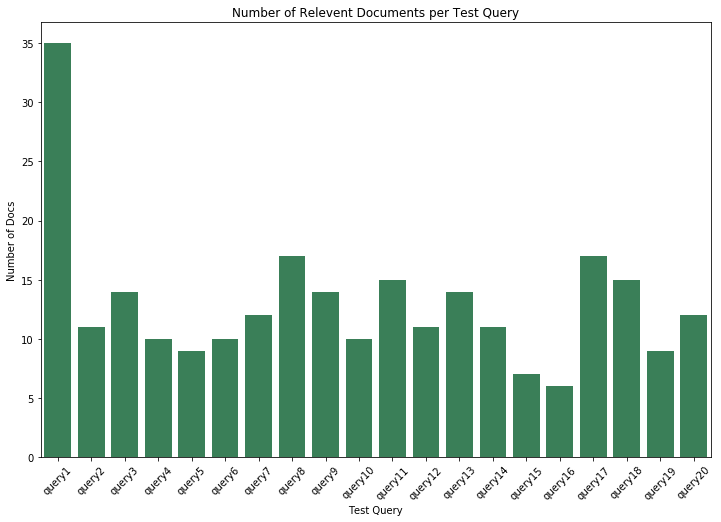

In [212]:
fig_dims = (12, 8)
fig, ax = plt.subplots(figsize=fig_dims)
g = sns.barplot(x=query_cols, y=num_relevant_docs, ax=ax, color='seagreen')

# ax = sns.boxplot('Day', 'Count', data= gg)
g.set_title('Number of Relevent Documents per Test Query')
g.set_ylabel('Number of Docs')
g.set_xlabel('Test Query')
plt.xticks(rotation=45)

In [94]:
num_relevant_docs

[35, 11, 14, 10, 9, 10, 12, 17, 14, 10, 15, 11, 14, 11, 7, 6, 17, 15, 9, 12]

(0, 25)

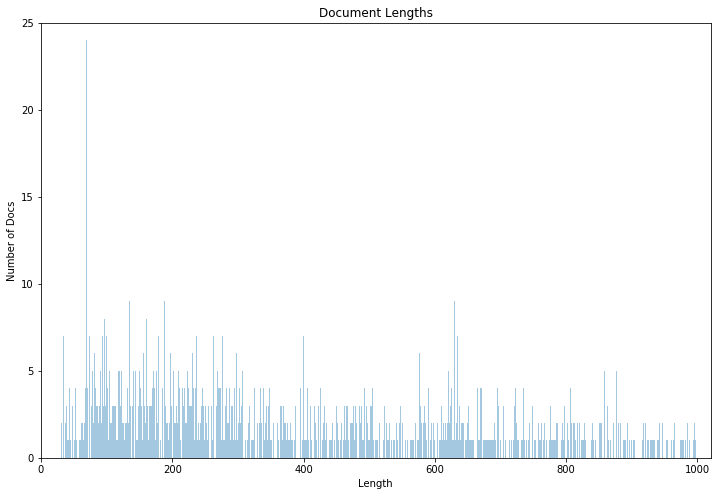

In [217]:
fig, ax = plt.subplots(figsize=(12, 8))
g = sns.distplot(filtered_doc_lengths,bins=750,kde=False,ax=ax)

# ax = sns.boxplot('Day', 'Count', data= gg)
g.set_title('Document Lengths')
g.set_ylabel('Number of Docs')
g.set_xlabel('Length')
plt.xlim(0,1020)
plt.ylim(0,25)

In [106]:
stops = stopwords.words('english')
punct = ['.', '?', '/', ':', ';', ',', '!', '@', '#', '$', '%', '&', '(', ')', "'", '"', '^', '_', '\\']
def clean(text):
    text = str(text)
    text = text.split()
    text = [word.lower() for word in text]
    text = [word.replace('-', ' ') for word in text]
    no_punct = []
    for x in text:
        new_text = []
        for y in x:
            if y not in punct:
                new_text.append(y)
        new_text = "".join(new_text)
        no_punct.append(new_text)
        
    filtered_text = [w for w in no_punct if not w in stops]
    final = " ".join(filtered_text)
    return final

In [107]:
filtered_cleaned_docs = [clean(x) for x in filtered_docs]

In [108]:
filtered_id_to_text = {filtered_ids[x]:filtered_cleaned_docs[x] for x in range(len(filtered_cleaned_docs))}

# Random baseline

In [111]:
# Random retrival

precision_scores_random = []
recall_scores_random = []

for q in q_list:
    print('Test query: '+ query_dict[q])
    
    doc_ids = list(df['text_id'])
    
    relevant = list(df[q])
    randomlist = random.sample(doc_ids, 10)
    print(randomlist)
    returned = [0]*len(relevant)
    for x in randomlist:
        idx = doc_ids.index(x)
        returned[idx] = 1
    
#     print('Returned articles:')
#     for x in randomlist:
#         print(id_to_text[x])
#         print()
    
    
    precision = average_precision_score(relevant, returned)
    print('Precision: ' + str(precision))
    precision_scores_random.append(precision)

    recall = recall_score(relevant, returned, average='macro')
#     recall_score(y_true, y_pred, average='micro')
#     recall_score(y_true, y_pred, average='weighted')
    print('Recall: ' + str(recall))
    recall_scores_random.append(recall)
    
    
    print('-'*100)
    
    
# #Generate 5 random numbers between 10 and 30
# randomlist = random.sample(range(10, 30), 5)

Test query: approach and landing tests
[293, 2234, 3193, 3346, 330, 3434, 2365, 4057, 3755, 2191]
Precision: 0.01978021978021978
Recall: 0.4971973094170404
----------------------------------------------------------------------------------------------------
Test query: first space shuttle launch
[3035, 2154, 2263, 42, 3525, 3485, 48, 4016, 4097, 3805]
Precision: 0.04130869130869132
Recall: 0.5886979245188201
----------------------------------------------------------------------------------------------------
Test query: sally ride
[157, 2143, 3565, 2261, 3798, 3556, 212, 3302, 3552, 2119]
Precision: 0.007692307692307693
Recall: 0.49723145071982283
----------------------------------------------------------------------------------------------------
Test query: STS-26
[3080, 94, 3634, 4145, 179, 2363, 3290, 3000, 3256, 2081]
Precision: 0.006043956043956044
Recall: 0.4972360420121614
----------------------------------------------------------------------------------------------------
Test que

# BM-25

In [112]:
text_to_id = {v: k for k, v in filtered_id_to_text.items()}

In [113]:
# save filtered_id_to_text and filtered_text_to_id
import json

json_file = json.dumps(filtered_id_to_text)
f = open("filtered_id_to_text.json","w")
f.write(json_file)
f.close()


json_file = json.dumps(text_to_id)
f = open("filtered_text_to_id.json","w")
f.write(json_file)
f.close()

In [114]:
corpus = list(filtered_id_to_text.values())

tokenized_corpus = [doc.split() for doc in corpus]

bm25 = BM25Okapi(tokenized_corpus)

In [115]:
bm25

In [116]:
# query = "STS-51j"
# tokenized_query = query.split(" ")

# results = bm25.get_top_n(tokenized_query, corpus, n=10)
# # ['It is quite windy in London']

# for x in results:
#     print(x)
#     print()
    


precision_scores_bm25 = []
recall_scores_bm25 = []

for q in q_list:
    print('Test query: '+ query_dict[q])
    query = clean(query_dict[q])
    
    
    tokenized_query = query.split()
    results = bm25.get_top_n(tokenized_query, corpus, n=10)
    
    
    returned_ids = []
    for x in results:
        returned_ids.append(text_to_id[x])
        
    # Now we have a list of ids
    
    doc_ids = list(df['text_id'])
    relevant = list(df[q])
    returned = [0]*len(relevant)
    for x in returned_ids:
        idx = doc_ids.index(x)
        returned[idx] = 1
    

    
    precision = average_precision_score(relevant, returned)
    print('Precision: ' + str(precision))
    precision_scores_bm25.append(precision)

    recall = recall_score(relevant, returned, average='macro')
#     recall_score(y_true, y_pred, average='micro')
#     recall_score(y_true, y_pred, average='weighted')
    print('Recall: ' + str(recall))
    recall_scores_bm25.append(recall)
    
    
    print('-'*100)
    
    
# #Generate 5 random numbers between 10 and 30
# randomlist = random.sample(range(10, 30), 5)

Test query: approach and landing tests
Precision: 0.19316239316239317
Recall: 0.6105505729945192
----------------------------------------------------------------------------------------------------
Test query: first space shuttle launch
Precision: 0.006043956043956044
Recall: 0.4972360420121614
----------------------------------------------------------------------------------------------------
Test query: sally ride
Precision: 0.3538461538461538
Recall: 0.7491694352159468
----------------------------------------------------------------------------------------------------
Test query: STS-26
Precision: 0.33001998001997995
Recall: 0.7716216895321373
----------------------------------------------------------------------------------------------------
Test query: last space shuttle launch
Precision: 0.015506715506715507
Recall: 0.5530707405362292
----------------------------------------------------------------------------------------------------
Test query: untethered space walk
Precision: 0

# BM25L

In [117]:
bm25 = BM25L(tokenized_corpus)


# query = "STS-51j"
# tokenized_query = query.split(" ")

# results = bm25.get_top_n(tokenized_query, corpus, n=10)
# # ['It is quite windy in London']

# for x in results:
#     print(x)
#     print()
    


precision_scores_bm25L = []
recall_scores_bm25L = []

for q in q_list:
    print('Test query: '+ query_dict[q])
    query = clean(query_dict[q])
    
    
    tokenized_query = query.split()
    results = bm25.get_top_n(tokenized_query, corpus, n=10)
    
    
    returned_ids = []
    for x in results:
        returned_ids.append(text_to_id[x])
        
    # Now we have a list of ids
    
    doc_ids = list(df['text_id'])
    relevant = list(df[q])
    returned = [0]*len(relevant)
    for x in returned_ids:
        idx = doc_ids.index(x)
        returned[idx] = 1
    

    
    precision = average_precision_score(relevant, returned)
    print('Precision: ' + str(precision))
    precision_scores_bm25L.append(precision)

    recall = recall_score(relevant, returned, average='macro')
#     recall_score(y_true, y_pred, average='micro')
#     recall_score(y_true, y_pred, average='weighted')
    print('Recall: ' + str(recall))
    recall_scores_bm25L.append(recall)
    
    
    print('-'*100)
    
    
# #Generate 5 random numbers between 10 and 30
# randomlist = random.sample(range(10, 30), 5)

Test query: approach and landing tests
Precision: 0.08647741147741148
Recall: 0.5680430991529646
----------------------------------------------------------------------------------------------------
Test query: first space shuttle launch
Precision: 0.006043956043956044
Recall: 0.4972360420121614
----------------------------------------------------------------------------------------------------
Test query: sally ride
Precision: 0.2615384615384615
Recall: 0.7131782945736433
----------------------------------------------------------------------------------------------------
Test query: STS-26
Precision: 0.5834665334665335
Recall: 0.8630835720387959
----------------------------------------------------------------------------------------------------
Test query: last space shuttle launch
Precision: 0.004945054945054945
Recall: 0.49723909442297076
----------------------------------------------------------------------------------------------------
Test query: untethered space walk
Precision: 0

# BM25+

In [118]:
bm25 = BM25Plus(tokenized_corpus)


# query = "STS-51j"
# tokenized_query = query.split(" ")

# results = bm25.get_top_n(tokenized_query, corpus, n=10)
# # ['It is quite windy in London']

# for x in results:
#     print(x)
#     print()
    


precision_scores_bm25plus = []
recall_scores_bm25plus = []

for q in q_list:
    print('Test query: '+ query_dict[q])
    query = clean(query_dict[q])
    
    
    tokenized_query = query.split()
    results = bm25.get_top_n(tokenized_query, corpus, n=10)
    
    
    returned_ids = []
    for x in results:
        returned_ids.append(text_to_id[x])
        
    # Now we have a list of ids
    
    doc_ids = list(df['text_id'])
    relevant = list(df[q])
    returned = [0]*len(relevant)
    for x in returned_ids:
        idx = doc_ids.index(x)
        returned[idx] = 1
    

    
    precision = average_precision_score(relevant, returned)
    print('Precision: ' + str(precision))
    precision_scores_bm25plus.append(precision)

    recall = recall_score(relevant, returned, average='macro')
#     recall_score(y_true, y_pred, average='micro')
#     recall_score(y_true, y_pred, average='weighted')
    print('Recall: ' + str(recall))
    recall_scores_bm25plus.append(recall)
    
    
    print('-'*100)
    
    
# #Generate 5 random numbers between 10 and 30
# randomlist = random.sample(range(10, 30), 5)

Test query: approach and landing tests
Precision: 0.23983516483516484
Recall: 0.6247197309417041
----------------------------------------------------------------------------------------------------
Test query: first space shuttle launch
Precision: 0.006043956043956044
Recall: 0.4972360420121614
----------------------------------------------------------------------------------------------------
Test query: sally ride
Precision: 0.3538461538461538
Recall: 0.7491694352159468
----------------------------------------------------------------------------------------------------
Test query: STS-26
Precision: 0.4476523476523476
Recall: 0.8173526307854666
----------------------------------------------------------------------------------------------------
Test query: last space shuttle launch
Precision: 0.004945054945054945
Recall: 0.49723909442297076
----------------------------------------------------------------------------------------------------
Test query: untethered space walk
Precision: 0

# TF-IDF

In [119]:
# TF

vocab = []
for x in corpus:
    for y in x.split():
        vocab.append(y)
vocab = list(set(vocab))

tf = {filtered_ids[x]:0 for x in range(len(filtered_ids))}


i=0
with tqdm(total=len(corpus)) as pbar:
    for doc in corpus:
        split_doc = doc.split()
        freq = [0]*len(vocab)
        for word in split_doc:
            idx = vocab.index(word)
            freq[idx]+=1
        freq = [x/len(split_doc) for x in freq]
        doc_id = text_to_id[doc]
        tf[doc_id] = freq
        i+=1
        pbar.update(1)


100%|██████████| 1762/1762 [06:00<00:00,  4.88it/s]


In [120]:
import json

json_file = json.dumps(tf)
f = open("tf.json","w")
f.write(json_file)
f.close()

In [121]:
doc_f = [0]*len(vocab)


with tqdm(total=len(corpus)) as pbar:
    for doc in corpus:
        split_doc = doc.split()
        uniques_in_doc = list(set(split_doc))
        
        for word in uniques_in_doc:
            idx = vocab.index(word)
            doc_f[idx]+=1
        
        pbar.update(1)

100%|██████████| 1762/1762 [03:44<00:00,  7.84it/s]


In [122]:
# import json

# json_file = json.dumps(doc_f)
# f = open("doc_f.json","w")
# f.write(json_file)
# f.close()

with open('doc_f.txt', 'w') as f:
    for item in doc_f:
        f.write("%s\n" % item)

In [124]:
N = len(corpus)

idf = np.array([np.log(N/(x+1)) for x in doc_f])

In [125]:
keys = list(tf.keys())
vals = list(tf.values())

tf_idf = {keys[x]:list(np.array(vals[x])*idf) for x in range(len(corpus))}

In [126]:
tf_idf = pd.DataFrame.from_dict(tf_idf, orient='index')
tf_idf.columns = vocab

In [127]:
#Use cosine similarity
    
precision_scores_tf_idf = []
recall_scores_tf_idf = []

for q in q_list:
    print('Test query: '+ query_dict[q])
    query = clean(query_dict[q])
    
    
    cols = []
    for word in query.split():
        cols.append(list(tf_idf[word]))

    cols = np.array(cols)
    res = list(np.sum(cols, 0))
    tf_idf_scores = {filtered_ids[x]:res[x] for x in range(len(res))}
    sorted_scores = dict(sorted(tf_idf_scores.items(), key=lambda x: x[1], reverse=True))
    # sorted_scores.keys()
    returned_ids = list(sorted_scores.keys())[:10]
      
        
    # Now we have a list of ids
    
    doc_ids = list(df['text_id'])
    relevant = list(df[q])
    returned = [0]*len(relevant)
    for x in returned_ids:
        idx = doc_ids.index(x)
        returned[idx] = 1
    

    
    precision = average_precision_score(relevant, returned)
    print('Precision: ' + str(precision))
    precision_scores_tf_idf.append(precision)

    recall = recall_score(relevant, returned, average='macro')
#     recall_score(y_true, y_pred, average='micro')
#     recall_score(y_true, y_pred, average='weighted')
    print('Recall: ' + str(recall))
    recall_scores_tf_idf.append(recall)
    
    
    print('-'*100)

Test query: approach and landing tests
Precision: 0.19316239316239317
Recall: 0.6105505729945192
----------------------------------------------------------------------------------------------------
Test query: first space shuttle launch
Precision: 0.006043956043956044
Recall: 0.4972360420121614
----------------------------------------------------------------------------------------------------
Test query: sally ride
Precision: 0.3538461538461538
Recall: 0.7491694352159468
----------------------------------------------------------------------------------------------------
Test query: STS-26
Precision: 0.33001998001997995
Recall: 0.7716216895321373
----------------------------------------------------------------------------------------------------
Test query: last space shuttle launch
Precision: 0.015506715506715507
Recall: 0.5530707405362292
----------------------------------------------------------------------------------------------------
Test query: untethered space walk
Precision: 0

# Axiomatic

In [128]:
vocab = []
for x in corpus:
    for y in x.split():
        vocab.append(y)
vocab = list(set(vocab))

tf_counts = {filtered_ids[x]:[0]*len(vocab) for x in range(len(filtered_ids))}


i=0
with tqdm(total=len(corpus)) as pbar:
    for doc in corpus:
        split_doc = doc.split()
        freq = [0]*len(vocab)
        for word in split_doc:
            idx = vocab.index(word)
            freq[idx]+=1
        doc_id = text_to_id[doc]
        tf_counts[doc_id] = freq
        i+=1
        pbar.update(1)
        
# tf_counts has doc ids as keys, and count of number of times each word appears in the doc

100%|██████████| 1762/1762 [06:09<00:00,  4.77it/s]


In [129]:
keys = list(tf_counts.keys())
vals = list(tf_counts.values())

keys1 = keys[:900]
vals1 = vals[:900]
tf_counts1 = {keys1[x]:vals1[x] for x in range(len(keys1))}

keys2 = keys[900:]
vals2 = vals[900:]
tf_counts2 = {keys2[x]:vals2[x] for x in range(len(keys2))}


import json

json = json.dumps(tf_counts1)
f = open("tf_counts1.json","w")
f.write(json)
f.close()

import json

json = json.dumps(tf_counts2)
f = open("tf_counts2.json","w")
f.write(json)
f.close()

In [130]:
# json = json.dumps(tf_counts)
# f = open("tf_counts.json","w")
# f.write(json)
# f.close()

import json

json_file = json.dumps(vocab)
f = open("vocab.json","w")
f.write(json_file)
f.close()

In [131]:
# Score for one document

# use doc_freq

precision_scores_axiomatic = []
recall_scores_tf_axiomatic = []



# scores = {q:[] for q in q_list} # add one entry for each word in the query, sum to get the total score
            
            
for q in q_list:
    
    res = {}
    print('Test query: '+ query_dict[q])
    query = clean(query_dict[q])
    
    
    query_split = query.split()
    query_word_counts = dict(Counter(query_split))
    
    query_scores = []
    for doc_id in filtered_ids:
        
        d = filtered_id_to_text[doc_id]
        dl = len(d.split())
        # avg_dl
        
        doc_word_counts = tf_counts[doc_id]
#         print(len(doc_word_counts))
        
        query_score = []
        for word in query_split:
            idx = vocab.index(word)
            t_f_d_t = doc_word_counts[idx]
            t_f_q_t = query_word_counts[word]
            d_f_t = doc_f[idx]
            # dl
            # avg_dl
            
            ax = t_f_d_t / (t_f_d_t + 0.5 + 0.5 * (dl/avg_dl))*((N/d_f_t)**0.35)*t_f_q_t
            
            query_score.append(ax)
                
        doc_score_for_query = sum(query_score)
        res[doc_id] = doc_score_for_query
        
    #sort res
      
    sorted_scores = dict(sorted(res.items(), key=lambda x: x[1], reverse=True))
    # sorted_scores.keys()
    returned_ids = list(sorted_scores.keys())[:10]
      
        
    # Now we have a list of ids
    
    doc_ids = list(df['text_id'])
    relevant = list(df[q])
    returned = [0]*len(relevant)
    for x in returned_ids:
        idx = doc_ids.index(x)
        returned[idx] = 1
    

    
    precision = average_precision_score(relevant, returned)
    print('Precision: ' + str(precision))
    precision_scores_axiomatic.append(precision)

    recall = recall_score(relevant, returned, average='macro')
#     recall_score(y_true, y_pred, average='micro')
#     recall_score(y_true, y_pred, average='weighted')
    print('Recall: ' + str(recall))
    recall_scores_tf_axiomatic.append(recall)
    
    
    print('-'*100)

Test query: approach and landing tests
Precision: 0.23983516483516484
Recall: 0.6247197309417041
----------------------------------------------------------------------------------------------------
Test query: first space shuttle launch
Precision: 0.006043956043956044
Recall: 0.4972360420121614
----------------------------------------------------------------------------------------------------
Test query: sally ride
Precision: 0.2615384615384615
Recall: 0.7131782945736433
----------------------------------------------------------------------------------------------------
Test query: STS-26
Precision: 0.5834665334665335
Recall: 0.8630835720387959
----------------------------------------------------------------------------------------------------
Test query: last space shuttle launch
Precision: 0.015506715506715507
Recall: 0.5530707405362292
----------------------------------------------------------------------------------------------------
Test query: untethered space walk
Precision: 0.

# Divergence from randomness

In [132]:
# Score for one document

# use doc_freq

precision_scores_dfr = []
recall_scores_tf_dfr = []



# scores = {q:[] for q in q_list} # add one entry for each word in the query, sum to get the total score
            
            
for q in q_list:
    
    res = {}
    print('Test query: '+ query_dict[q])
    query = clean(query_dict[q])
    
    
    query_split = query.split()
    query_word_counts = dict(Counter(query_split))
    
    query_scores = []
    for doc_id in filtered_ids:
        
        d = filtered_id_to_text[doc_id]
        dl = len(d.split())
        # avg_dl
        
        doc_word_counts = tf_counts[doc_id]
#         print(len(doc_word_counts))
        
        query_score = []
        for word in query_split:
            idx = vocab.index(word)
            t_f_d_t = doc_word_counts[idx]
            t_f_q_t = query_word_counts[word]
            d_f_t = doc_f[idx]
            # dl
            # avg_dl
            
            dfr = (((t_f_d_t*np.log(1+(avg_dl/dl)))/(1+t_f_d_t*np.log(1+(avg_dl/dl))))*np.log((N+1)/(d_f_t+0.5))*t_f_q_t)
            
            query_score.append(dfr)
                
        doc_score_for_query = sum(query_score)
        res[doc_id] = doc_score_for_query
        
    #sort res
      
    sorted_scores = dict(sorted(res.items(), key=lambda x: x[1], reverse=True))
    # sorted_scores.keys()
    returned_ids = list(sorted_scores.keys())[:10]
#     print(returned_ids)
      
        
    # Now we have a list of ids
    
    doc_ids = list(df['text_id'])
    relevant = list(df[q])
    returned = [0]*len(relevant)
    for x in returned_ids:
        idx = doc_ids.index(x)
        returned[idx] = 1
#         print(filtered_id_to_text[x])
#         print('-'*100)
        

    

    
    precision = average_precision_score(relevant, returned)
    print('Precision: ' + str(precision))
    precision_scores_dfr.append(precision)

    recall = recall_score(relevant, returned, average='macro')
#     recall_score(y_true, y_pred, average='micro')
#     recall_score(y_true, y_pred, average='weighted')
    print('Recall: ' + str(recall))
    recall_scores_tf_dfr.append(recall)
    
    
    print('-'*100)

Test query: approach and landing tests
[8, 6, 27, 7, 5, 9, 2, 1, 125, 28]
Precision: 0.23983516483516484
Recall: 0.6247197309417041
----------------------------------------------------------------------------------------------------
Test query: first space shuttle launch
[312, 2256, 3000, 2310, 282, 129, 302, 3364, 3333, 2376]
Precision: 0.006043956043956044
Recall: 0.4972360420121614
----------------------------------------------------------------------------------------------------
Test query: sally ride
[114, 184, 110, 111, 108, 121, 116, 183, 120, 189]
Precision: 0.3538461538461538
Recall: 0.7491694352159468
----------------------------------------------------------------------------------------------------
Test query: STS-26
[322, 327, 323, 319, 321, 325, 2017, 326, 324, 3012]
Precision: 0.5834665334665335
Recall: 0.8630835720387959
----------------------------------------------------------------------------------------------------
Test query: last space shuttle launch
[2039, 2042

# Naive

In [134]:
# Naive approach

tf_counts


# Score for one document

# use doc_freq

precision_scores_naive = []
recall_scores_tf_naive = []



# scores = {q:[] for q in q_list} # add one entry for each word in the query, sum to get the total score
            
            
for q in q_list:
    
    res = {}
    print('Test query: '+ query_dict[q])
    query = clean(query_dict[q])
    
    
    query_split = query.split()
    query_word_counts = dict(Counter(query_split))
    
    query_scores = []
    for doc_id in filtered_ids:
        
        d = filtered_id_to_text[doc_id]
        dl = len(d.split())
        # avg_dl
        
        doc_word_counts = tf_counts[doc_id]
#         print(len(doc_word_counts))
        
        query_score = []
        for word in query_split:
            idx = vocab.index(word)
            t_f_d_t = doc_word_counts[idx]
#             t_f_q_t = query_word_counts[word]
#             d_f_t = doc_f[idx]
#             # dl
#             # avg_dl
            
#             dfr = (((t_f_d_t*np.log(1+(avg_dl/dl)))/(1+t_f_d_t*np.log(1+(avg_dl/dl))))*np.log((N+1)/(d_f_t+0.5))*t_f_q_t)
            
            query_score.append(t_f_d_t)
                
        doc_score_for_query = sum(query_score)
        res[doc_id] = doc_score_for_query
        
    #sort res
      
    sorted_scores = dict(sorted(res.items(), key=lambda x: x[1], reverse=True))
    # sorted_scores.keys()
    returned_ids = list(sorted_scores.keys())[:10]
      
        
    # Now we have a list of ids
    
    doc_ids = list(df['text_id'])
    relevant = list(df[q])
    returned = [0]*len(relevant)
    for x in returned_ids:
        idx = doc_ids.index(x)
        returned[idx] = 1
    

    
    precision = average_precision_score(relevant, returned)
    print('Precision: ' + str(precision))
    precision_scores_naive.append(precision)

    recall = recall_score(relevant, returned, average='macro')
#     recall_score(y_true, y_pred, average='micro')
#     recall_score(y_true, y_pred, average='weighted')
    print('Recall: ' + str(recall))
    recall_scores_tf_naive.append(recall)
    
    
    print('-'*100)

Test query: approach and landing tests
Precision: 0.04313186813186813
Recall: 0.539704783258595
----------------------------------------------------------------------------------------------------
Test query: first space shuttle launch
Precision: 0.006043956043956044
Recall: 0.4972360420121614
----------------------------------------------------------------------------------------------------
Test query: sally ride
Precision: 0.18351648351648353
Recall: 0.67718715393134
----------------------------------------------------------------------------------------------------
Test query: STS-26
Precision: 0.04130869130869132
Recall: 0.5886979245188201
----------------------------------------------------------------------------------------------------
Test query: last space shuttle launch
Precision: 0.004945054945054945
Recall: 0.49723909442297076
----------------------------------------------------------------------------------------------------
Test query: untethered space walk
Precision: 0.

In [153]:
avg_precision_scores_random = statistics.mean(precision_scores_random)
avg_recall_scores_random = statistics.mean(recall_scores_random)


avg_recall_scores_bm25 = statistics.mean(recall_scores_bm25)
avg_precision_scores_bm25 = statistics.mean(precision_scores_bm25)


avg_recall_scores_tf_idf = statistics.mean(recall_scores_tf_idf)
avg_precision_scores_tf_idf = statistics.mean(precision_scores_tf_idf)


avg_recall_scores_bm25L = statistics.mean(recall_scores_bm25L)
avg_precision_scores_bm25L = statistics.mean(precision_scores_bm25L)


avg_recall_scores_bm25plus = statistics.mean(recall_scores_bm25plus)
avg_precision_scores_bm25plus = statistics.mean(precision_scores_bm25plus)


avg_recall_scores_axiomatic = statistics.mean(recall_scores_tf_axiomatic)
avg_precision_scores_axiomatic = statistics.mean(precision_scores_axiomatic)


avg_recall_scores_dfr = statistics.mean(recall_scores_tf_dfr)
avg_precision_scores_dfr = statistics.mean(precision_scores_dfr)


avg_recall_scores_naive = statistics.mean(recall_scores_tf_naive)
avg_precision_scores_naive = statistics.mean(precision_scores_naive)

Text(0, 0.5, 'Score')

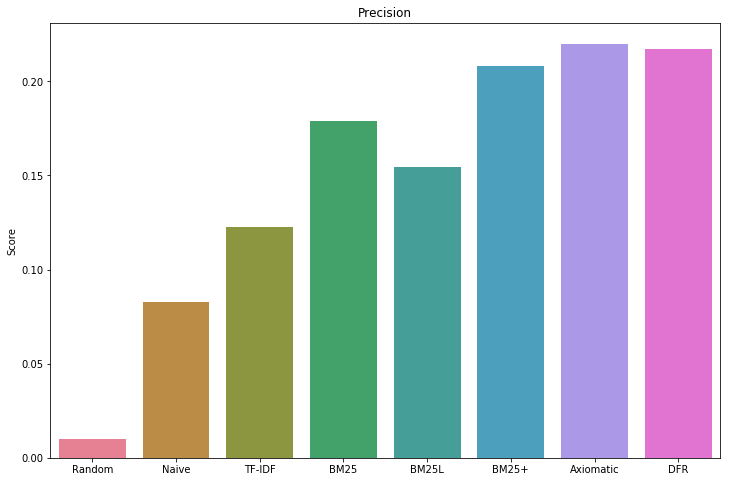

In [174]:
labels = ['Random', 
          'Naive', 
          'TF-IDF',
          'BM25', 
          'BM25L',  
          'BM25+',  
         'Axiomatic',
         'DFR']

vals = [avg_precision_scores_random, 
        avg_precision_scores_naive,
        avg_precision_scores_tf_idf,
        avg_precision_scores_bm25, 
        avg_precision_scores_bm25L, 
       avg_precision_scores_bm25plus, 
       avg_precision_scores_axiomatic,
       avg_precision_scores_dfr]

color = ['random','bm25','tf-idf','bm25L','bm25 plus','axiomatic', 'dfr', 'naive']

fig_dims = (12, 8)
fig, ax = plt.subplots(figsize=fig_dims)
g = sns.barplot(x=labels, y=vals, ax=ax, palette="husl")

# g.text(labels,vals, color='black', ha="center")

g.set_title('Precision')
g.set_ylabel('Score')

Text(0, 0.5, 'Score')

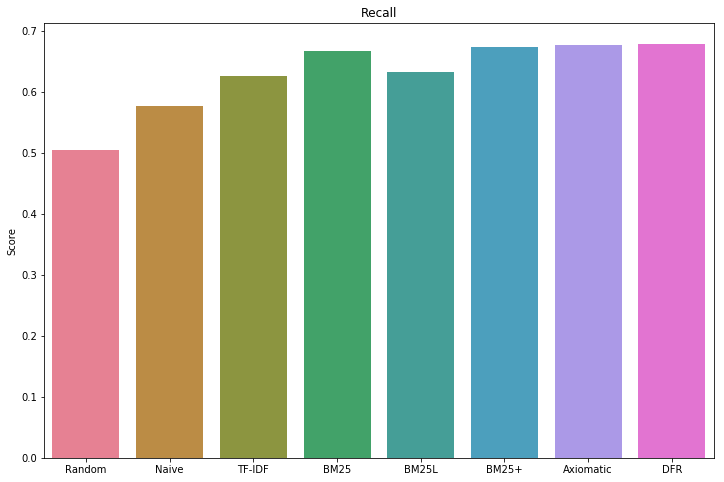

In [173]:
labels = ['Random', 
          'Naive', 
          'TF-IDF',
          'BM25', 
          'BM25L',  
          'BM25+',  
         'Axiomatic',
         'DFR']


vals = [avg_recall_scores_random, 
        avg_recall_scores_naive,
        avg_recall_scores_tf_idf,
        avg_recall_scores_bm25, 
        avg_recall_scores_bm25L, 
       avg_recall_scores_bm25plus, 
       avg_recall_scores_axiomatic,
       avg_recall_scores_dfr]

# color = ['random','bm25','tf-idf','bm25L','bm25 plus','axiomatic', 'dfr', 'naive']
# color = ['Blue','Blue','Blue','Blue','Blue','Blue','Blue','Blue',]
fig_dims = (12, 8)
fig, ax = plt.subplots(figsize=fig_dims)
g = sns.barplot(x=labels, y=vals, ax=ax, palette="husl")

# g.text(labels,vals, color='black', ha="center")

g.set_title('Recall')
g.set_ylabel('Score')
